In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.metrics import r2_score

In [2]:
sns.set(rc={"figure.figsize":(12, 8)})
pd.set_option("display.max_columns", None)

# Import data

In [3]:
#data = pd.read_csv('../../tresboncoin/data/master/master_with_fuzzy_and_cleaning.csv')
data = pd.read_csv('master_with_fuzzy_and_cleaning.csv')
data.drop_duplicates(subset=['model_db', 'brand_db', 'price', 'engine_size', 'mileage', 'bike_year'], inplace=True)
#data.drop(columns=['Unnamed: 0'], inplace=True)
data.shape

(28176, 23)

# Feature engineering

## Calculated

In [4]:
def km_per_year(km, bike_year):
    if (datetime.now().year- bike_year) == 0:
        return km
    return km / (datetime.now().year- bike_year)

data['km/year'] = data.apply(lambda x: km_per_year(x['mileage'],x['bike_year']), axis=1)

In [5]:
def age(bike_year):
    return datetime.now().year - bike_year

data['age'] = data.bike_year.apply(age)

In [6]:
data = data[data.engine_size<2000]
data = data[data.engine_size>=49]

# Explore data

In [7]:
data.model.nunique()

5606

In [8]:
data.model_submodel_db.nunique()

2465

## Price
### vs mileage (km) per category

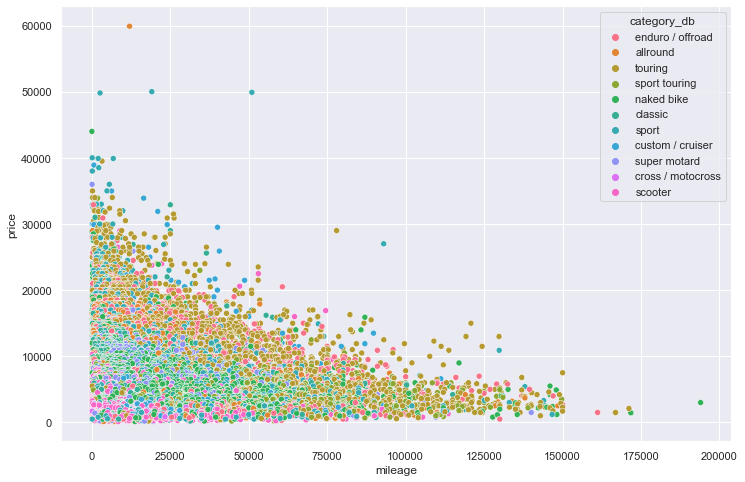

In [16]:
sns.scatterplot(x='mileage', y='price', hue='category_db', data=data);

### vs mileage (km) per engine size

In [ ]:
sns.scatterplot(x='mileage', y='price', hue='engine_size', data=data);

### vs mileage (km) per power range

In [ ]:
sns.scatterplot(x='mileage', y='price', hue='power_db', data=data);

### vs year of release per category

In [ ]:
sns.scatterplot(x='age', y='price', hue='category_db',data=data);

### vs year of release per engine size

In [ ]:
sns.scatterplot(x='age', y='price', hue='engine_size', data=data);

### vs km/year

In [ ]:
sns.scatterplot(x='km/year', y='price', hue='engine_size',data=data);

### Price/cc vs km

In [ ]:
data['price/cc/km'].mean()

### Average price per engine size

In [10]:
data.groupby('engine_size').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
engine_size,,,
49.0,1505.250000,705.085785,36
49.1,730.000000,450.777107,3
49.2,1720.000000,537.587202,10
49.3,1650.000000,804.673847,3
49.4,1520.833333,583.663327,12
...,...,...,...
1890.0,20663.333333,282.901632,3
1900.0,14893.333333,7453.591975,3
1901.0,28990.000000,NaN,1


In [ ]:
#engine_size_count_threshold = 3
#groupby_engine_size = data.groupby('engine_size').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#groupby_engine_size[groupby_engine_size.Count < 4]
#groupby_engine_size

### Average price per category

In [11]:
data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
category_db,,,
allround,8305.067895,5356.842628,1900
atv,8772.666667,7600.328620,72
classic,8236.258798,4052.789441,1364
cross / motocross,7101.605911,5070.950435,203
custom / cruiser,9161.371075,6493.604297,1051
enduro / offroad,9382.505458,6281.045600,2107
"minibike, cross",6666.312500,4171.357066,32
"minibike, sport",1912.500000,85.391256,4
naked bike,6943.254890,4401.554845,4959


In [12]:
category_count_threshold = 200
groupby_category = data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_category = groupby_category[groupby_category .Count < category_count_threshold].index.to_list()
drop_category.append('unspecified category')

In [13]:
data = data[data.category_db.isin(drop_category) == False]

### Average price per brand

In [14]:
data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
brand_db,,,
ace,4290.000000,NaN,1
adler,5546.333333,2033.489693,3
adly,11490.000000,NaN,1
alta,22000.000000,NaN,1
aprilia,7966.126697,5476.788327,221
...,...,...,...
voxan,9992.500000,6681.817991,4
xingyue,8108.333333,4892.346915,3
xmotos,2499.000000,NaN,1


In [15]:
brand_count_threshold = 200
groupby_brand = data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_brand = groupby_brand[groupby_brand.Count < brand_count_threshold].index.to_list()
data = data[data.brand_db.isin(drop_brand) == False]

### Average price per model

In [ ]:
data.groupby(['brand_db','model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

In [ ]:
#model_count_threshold = 1
#groupby_model = data.groupby(['model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#drop_model = groupby_model[groupby_model.Count < model_count_threshold].index.to_list()
#data = data[data.model_db.isin(drop_model) == False]

## Correlation matrix

In [ ]:
sns.heatmap(data.corr(), annot = True, mask=np.triu(np.ones_like(data.corr(), dtype=bool)));

# BASELINE

In [ ]:
# mean
average_price = data.price.mean()

#rmse
rmse_baseline = np.sqrt(sum((data['price']-average_price)**2)/((data['price'].count())))

print("Average price :", average_price)
print("RMSE Baseline", rmse_baseline )

In [ ]:
sns.displot(data.price)

# LINEAR REGRESSION

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

## Numerical features (not scaled)

In [ ]:
data_1 = data.copy()
data_1.shape

In [ ]:
features_1 = ['bike_year', 'mileage', 'km/year', 'engine_size']

In [ ]:
for feature in features_1:
    data_1.dropna(subset=[feature],inplace=True)
data_1.shape  

In [ ]:
X = data_1[features_1]
y = data_1['price']

model_1 = LinearRegression()

cv_results = cross_validate(model_1, X, y, cv=5)
cv_results['test_score'].mean()

## Numerical features (not scaled) + brand encoded

In [ ]:
data_2 = data.copy()[['brand', 'bike_year', 'mileage', 'engine_size', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand']])

feature_encoded = ohe.transform(data_2[['brand']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand', 'price'])
y = data_2['price']

model_2 = LinearRegression()

cv_results = cross_validate(model_2, X, y, cv=5)
cv_results['test_score'].mean()

# KNR

## KNeighborsRegressor - Numerical features (not scaled) + brand encoded

In [ ]:
data_2 = data.copy()[['brand', 'bike_year', 'mileage', 'engine_size', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand']])

feature_encoded = ohe.transform(data_2[['brand']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand', 'price'])
y = data_2['price']

In [ ]:
model_3 = KNeighborsRegressor(n_neighbors=5)

cv_results = cross_validate(model_3, X, y, cv=5)
cv_results['test_score'].mean()

## KNeighborsRegressor - Numerical features (scaled) + brand encoded

### Brand

### Category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['category_db','brand_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

### Brand and category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

# PIPELINE

In [39]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn import set_config

set_config(display='diagram')

## Pipeline Baseline

### Category

In [ ]:
data_1=data.copy()[['age','mileage','engine_size','km/year', 'category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year', 'category_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.3, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

### Brand

In [ ]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

### Brand & Category

In [41]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db','category_db',]] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db', 'category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.8148180093023172

## Pipeline gridsearch

In [42]:
# Instanciate grid search
grid_search = GridSearchCV(
    final_pipe, 
    param_grid={
        'preprocessing__num_transformer__scaler': [StandardScaler()], #MinMaxScaler(), RobustScaler(), 
        'KNeighborsRegressor__n_neighbors': list(range(9,13)),
        #'KNeighborsRegressor__leaf_size': [1,2,3],
        'KNeighborsRegressor__metric': ['euclidean',
                                        'manhattan'],
        'KNeighborsRegressor__weights': ['uniform', 'distance']},
    cv=3,
    scoring=['r2', 'neg_root_mean_squared_error'],
    refit='r2')

grid_search.fit(X_1, y_1)
print("best_params",grid_search.best_params_)
print("best_score",grid_search.best_score_)

best_params {'KNeighborsRegressor__metric': 'euclidean', 'KNeighborsRegressor__n_neighbors': 12, 'KNeighborsRegressor__weights': 'distance', 'preprocessing__num_transformer__scaler': StandardScaler()}
best_score 0.7642550908149949


In [43]:
print(grid_search.score(X_1,y_1))
print(final_pipe_trained.score(X_1,y_1))

0.9988877154636836
0.864180845106203


In [44]:
grid_search.cv_results_

{'mean_fit_time': array([0.01758432, 0.01547941, 0.01520769, 0.01511312, 0.01500734,
        0.01484799, 0.01515293, 0.01500726, 0.01534883, 0.01551676,
        0.01570702, 0.01557827, 0.0157276 , 0.01536568, 0.01543864,
        0.01662238]),
 'std_fit_time': array([1.92996331e-03, 1.63233501e-04, 8.93867964e-05, 4.43296163e-05,
        7.77291698e-05, 1.93918305e-04, 2.00339998e-04, 1.08377614e-04,
        4.30647771e-04, 9.41007657e-05, 2.14624664e-04, 1.45942943e-04,
        7.17707256e-04, 9.11653816e-05, 1.76312577e-04, 5.78632357e-04]),
 'mean_score_time': array([1.96037968, 1.90145159, 1.82780234, 1.82696899, 1.84367601,
        1.83757091, 1.83593067, 1.8364497 , 3.16724126, 3.20161025,
        3.16953937, 3.31987484, 3.17844741, 3.18471034, 3.17394296,
        3.59594504]),
 'std_score_time': array([0.08230332, 0.08936787, 0.08042158, 0.08385987, 0.08642045,
        0.08677661, 0.09713455, 0.09084801, 0.08715065, 0.08430433,
        0.08268421, 0.05552036, 0.05756343, 0.055200

## Optimized Pipeline

In [45]:
num_transformer = Pipeline([('scaler', grid_search.best_params_['preprocessing__num_transformer__scaler'])])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db']),
])

# Combine preprocessor and Regression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor(
        #leaf_size=grid_search.best_params_['KNeighborsRegressor__leaf_size'],
        metric=grid_search.best_params_['KNeighborsRegressor__metric'], 
        n_neighbors=grid_search.best_params_['KNeighborsRegressor__n_neighbors'], 
        weights=grid_search.best_params_['KNeighborsRegressor__weights']))])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.8288583228453915

In [48]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(final_pipe, X_1, y_1, cv=3, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

r2 0.7747131082934632
RMSE -2569.6158805756536


## Prediction

In [ ]:
X_pred = pd.DataFrame([[10,5000,800,1000,'bmw']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])

In [ ]:
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[4,2347,1200,586,'triumph']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[6,26500,990,4416,'ktm']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )